# Predicting Loan Defaults

### Names:
Hayden Strikwerda, Bryce Kastner, and Hannah George

### Project Purpose

Our project is to predict loan defaults using machine learning. Through this project we hope to gain a clearer understanding of what factors most strongly influence whether a loan is approved or not and to use this information to create a machine learning algorithm which predicts whether a loan would be approved or not.

In order to do so we first found our dataset (located at http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff) and cleaned it, turning each of the columns into numerical data. 

## Imports

In [10]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn import tree, svm, metrics
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Loading the Data

In [20]:
data = pd.DataFrame(arff.loadarff('german_credit_fruad.arff.txt')[0])

## Cleaning the Data

The following code is for cleaning the data. First we deleted some of the columns that felt unnessary, and rename others. Then we go through and change the type of the data from bytes to string. Then, in order to make the data easier to work with, we changed the data type from strings to integers. We provide a key for the numerical values at the top of the code.  At the end, we saved our dataframe with the cleaned data into a csv file to save time. 

In [21]:
del data['employment']
del data['other_parties']
del data['property_magnitude']
del data['other_payment_plans']
del data['own_telephone']
del data['location']
del data['num_dependents']
del data['residence_since']

data.rename(columns={'over_draft':'checking_balance', 
                     'Average_Credit_Balance': 'savings_balance', 
                     'cc_age':'age'}, 
            inplace=True)

Here is the key for reference:

In [ ]:
'''
Attributes  age, credit_usage, current_balance, and existing_credits do not require a value key.

 Value Key for attribute checking_balance
    
    0     Represents: None        
    1     Represents: Less than 0                          
    2     Represents: In between 0 and 200                      
    3     Represents: Greater than 200  
    
 Value Key for attribute class
    0     Represents: Denied                                          
    1     Represents: Approved  

 Value Key for attribute credit_history
    0     Represents: None          
    1     Represents: Bad                                  
    2     Represents: Fair                        
    3     Represents: Good              
    4     Represents: Great
    
 Value Key for attribute foreign_worker
    0     Represents: No                                            
    1     Represents: Yes  
    
 Value Key for attribute gender
    0     Represents: Male
    1     Represents: Female
    
 Value Key for attribute housing
    0     Represents: Rent                                         
    1     Represents: Own                                           
    2     Represents: For Free 
    
Value Key for attribute job
    0     Represents: Unemployed       
    1     Represents: Unskilled             
    2     Represents: Skilled                                    
    3     Represents: Highly Skilled    
    
 Value Key for attribute purpose
    0     Represents: New Car                                  
    1     Represents: Used Car                                
    2     Represents: Furniture/Equipment            
    3     Represents: Radio/TV                                  
    4     Represents: Domestic Appliance            
    5     Represents: Repairs                                    
    6     Represents: Education                               
    7     Represents: Vacation                                  
    8     Represents: Retraining                              
    9     Represents: Business                                  
    10    Represents: Other                                        

 Value Key for attribute savings_balance
    0     Represents: None                            
    1     Represents: Less than 100                              
    2     Represents: Inbetween 100 and 500                      
    3     Represents: Inbetween 500 and 1000                               
    4     Represents: Greater than 1000                          

                       
'''             

This next bit of code is for changing the type of some of the columns from byte to string.

In [22]:
for column in data.columns:
    i = 0
    for item in data[column]:
        if isinstance(item, bytes) == True:
                fixed = item.decode("utf-8")
                fixed = fixed.replace("'","")
                data.loc[i, column] = str(fixed)
                item = str(fixed)
        i += 1

Next, we want to change the data into a more workable type so we convert some of the columns from a string to an integer. 

In [23]:
gender = []

for column in data.columns:
    
    relabeled = []
    
    for item in data[column]:
        if column == 'checking_balance':
            if item == 'no checking':
                relabeled.append(0)
            elif item == '<0':
                relabeled.append(1)
            elif item == '0<=X<200':
                relabeled.append(2)
            elif item == '>=200':
                relabeled.append(3)
            else:
                relabeled.append('ERROR')
        elif column == 'credit_history':
            if item == 'no credits/all paid':
                relabeled.append(0)
            elif item == 'all paid':
                relabeled.append(1)
            elif item == 'existing paid':
                relabeled.append(2)
            elif item == 'delayed previously':
                relabeled.append(3)
            elif item == 'critical/other existing credit':
                relabeled.append(4)
            else:
                relabeled.append('ERROR')
        elif column == 'purpose':
            if item == 'new car':
                relabeled.append(0)
            elif item == 'used car':
                relabeled.append(1)
            elif item == 'furniture/equipment':
                relabeled.append(2)
            elif item == 'radio/tv':
                relabeled.append(3)
            elif item == 'domestic appliance':
                relabeled.append(4)
            elif item == 'repairs':
                relabeled.append(5)
            elif item == 'education':
                relabeled.append(6)
            elif item == 'vacation':
                relabeled.append(7)
            elif item == 'retraining':
                relabeled.append(8)
            elif item == 'business':
                relabeled.append(9)
            elif item == 'other':
                relabeled.append(10)
            else:
                relabeled.append('ERROR')
        elif column == 'savings_balance':
            if item == 'no known savings':
                relabeled.append(0)
            elif item == '<100':
                relabeled.append(1)
            elif item == '100<=X<500':
                relabeled.append(2)
            elif item == '500<=X<1000':
                relabeled.append(3)
            elif item == '>=1000':
                relabeled.append(4)
        elif column == 'personal_status':
            if item == 'male single':
                relabeled.append(0)
                gender.append(0)
            elif item == 'male mar/wid':
                relabeled.append(1)
                gender.append(0)
            elif item == 'male div/sep':
                relabeled.append(2)
                gender.append(0)
            elif item == 'female single':
                relabeled.append(3)
                gender.append(1)
            elif item == 'female div/dep/mar':
                relabeled.append(4)
                gender.append(1)
        elif column == 'housing':
            if item == 'for free':
                relabeled.append(0)
            elif item == 'rent':
                relabeled.append(1)
            elif item == 'own':
                relabeled.append(2)
        elif column == 'job':
            if item == 'unemp/unskilled non res':
                relabeled.append(0)
            elif item == 'unskilled resident':
                relabeled.append(1)
            elif item == 'skilled':
                relabeled.append(2)
            elif item == 'high qualif/self emp/mgmt':
                relabeled.append(3)
        elif column == 'foreign_worker':
            if item == 'no':
                relabeled.append(0)
            elif item == 'yes':
                relabeled.append(1)
        elif column == 'class':
            if item == 'bad':
                relabeled.append(0)
            elif item == 'good':
                relabeled.append(1)
            
    if len(relabeled) != 0:
        data[column] = relabeled

data['gender'] = gender
del data['personal_status']

Now we save the data into a .csv file.

In [24]:
data.to_csv('cleanedData.csv')

## Loading the Data From the New .csv File

In [26]:
data = pd.read_csv('cleanedData.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.reindex(sorted(data.columns), axis=1)
data.head()

,age,checking_balance,class,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance
0,67.0,1,1,4,6.0,1169.0,2.0,1,0,2,2,3,0
1,22.0,2,0,2,48.0,5951.0,1.0,1,1,2,2,3,1
2,49.0,0,1,4,12.0,2096.0,1.0,1,0,2,1,6,1
3,45.0,1,1,2,42.0,7882.0,1.0,1,0,0,2,2,1
4,53.0,1,0,3,24.0,4870.0,2.0,1,0,0,2,0,1


## Visualizing the Data

This next code is here to understand the relationships between the variables.

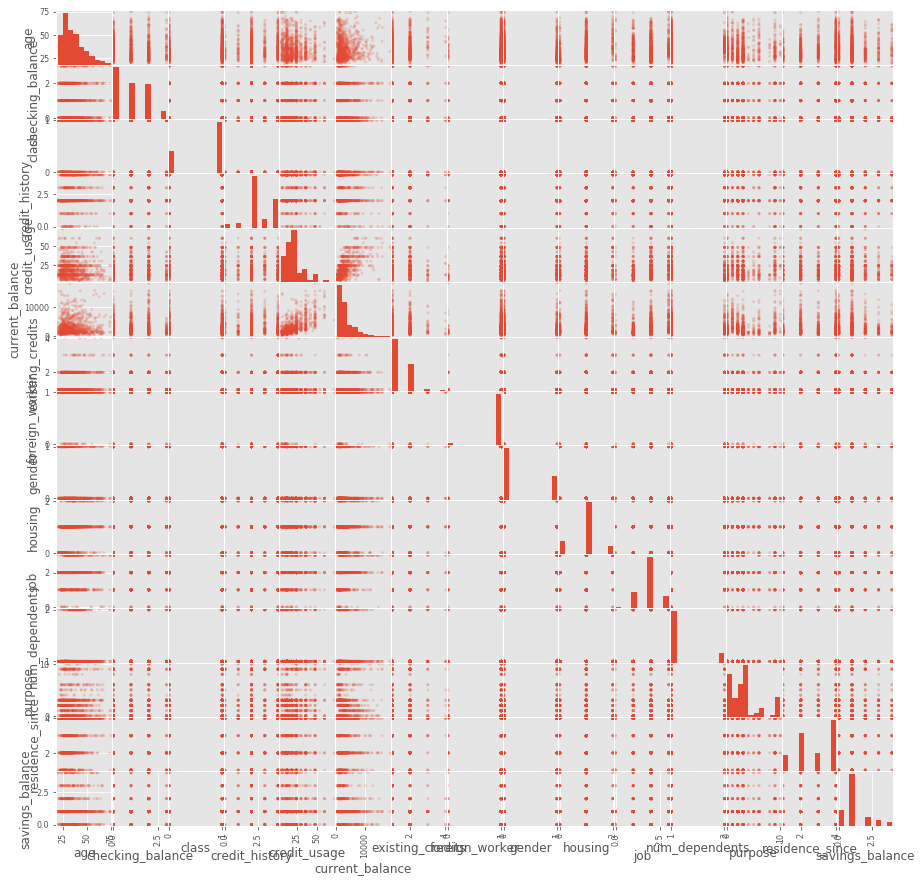

In [145]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = 0.2, figsize=(15, 15))
print('')

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

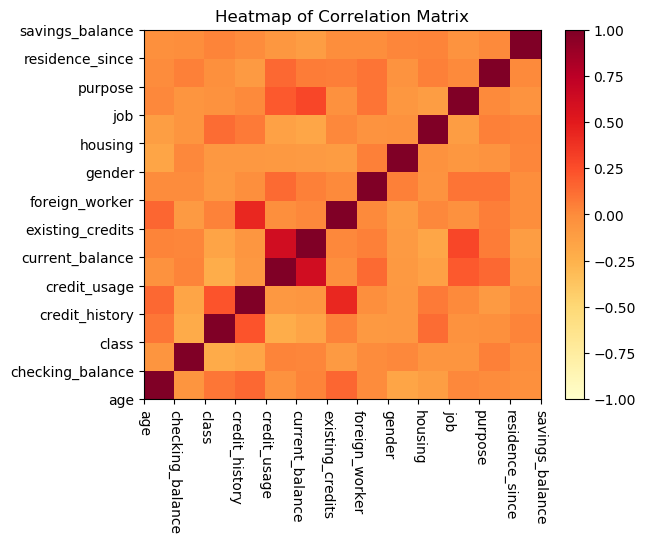

In [27]:
# Computing the correlation matrix
correlation = data.corr()

# Calculate and visualize correlations as matrix
plt.style.use('default')
heatmap = plt.pcolor(correlation, cmap=plt.cm.YlOrRd, vmin = -1, vmax = 1)

# Plot the legend on the side
plt.colorbar(heatmap)
plt.xticks(np.arange(14), ['age', 'checking_balance','class', 'credit_history',
           'credit_usage', 'current_balance', 'existing_credits',
           'foreign_worker', 'gender', 'housing', 'job',  
            'purpose', 'residence_since', 'savings_balance'], 
        rotation = -90)
plt.yticks(np.arange(14), ['age', 'checking_balance','class', 'credit_history',
           'credit_usage', 'current_balance', 'existing_credits',
           'foreign_worker', 'gender', 'housing', 'job',  
            'purpose', 'residence_since', 'savings_balance'])

plt.title("Heatmap of Correlation Matrix")

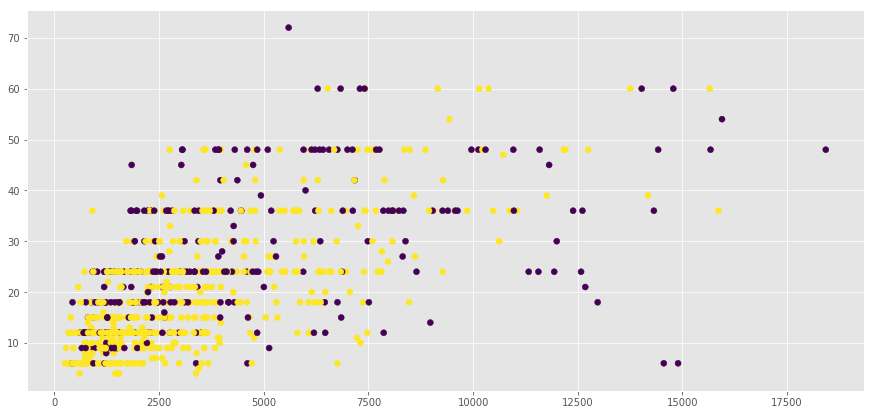

In [102]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(x = data['current_balance'], y = data['credit_usage'],c = data['class'])
plt.show()

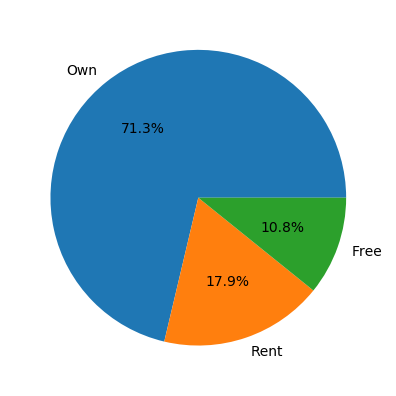

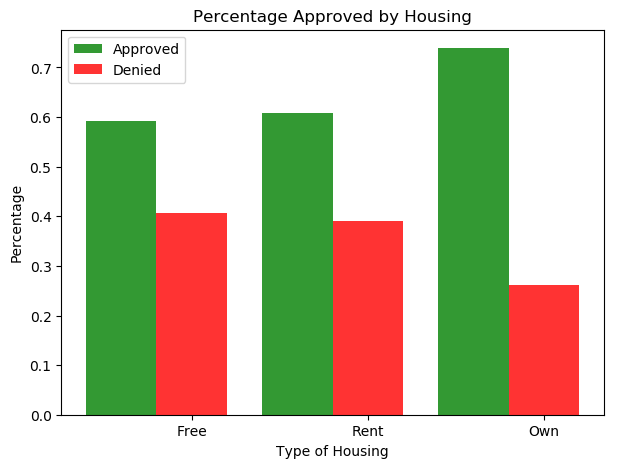

In [32]:
housing_value_counts = data['housing'].value_counts()

plt.pie(housing_value_counts, labels = ['Own', 'Rent', 'Free'], 
        radius = 1, autopct='%1.1f%%')

rent = data[data['housing'] == 1]
own = data[data['housing'] == 2]
free = data[data['housing'] == 0]

rent_percentages = rent['class'].value_counts() / len(rent)
own_percentages = own['class'].value_counts() / len(own)
free_percentages = free['class'].value_counts() / len(free)

housing_approved = [free_percentages[1],rent_percentages[1], own_percentages[1]]
housing_denied = [free_percentages[0], rent_percentages[0], own_percentages[0]]

# data to plot
n_groups = 3
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, housing_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, housing_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Type of Housing')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Housing')
plt.xticks(index + bar_width, ('Free','Rent','Own'))
plt.legend()

plt.show()


print('')

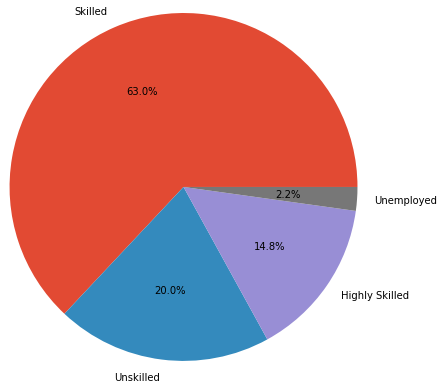

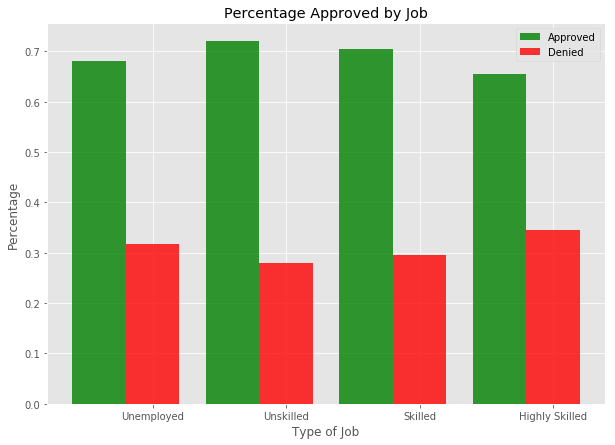

In [97]:
job_value_counts = data['job'].value_counts()

plt.pie(job_value_counts, labels = ['Skilled', 'Unskilled', 'Highly Skilled', 'Unemployed'],  
        radius = 2, autopct='%1.1f%%')


unemployed = data[data['job'] == 0]
unskilled = data[data['job'] == 1]
skilled = data[data['job'] == 2]
highly_skilled = data[data['job'] == 3]

unemployed_percentages = unemployed['class'].value_counts() / len(unemployed)
unskilled_percentages = unskilled['class'].value_counts() / len(unskilled)
skilled_percentages = skilled['class'].value_counts() / len(skilled)
highly_skilled_percentages = highly_skilled['class'].value_counts() / len(highly_skilled)

job_approved = [unemployed_percentages[1], unskilled_percentages[1], skilled_percentages[1], highly_skilled_percentages[1]]
job_denied = [unemployed_percentages[0], unskilled_percentages[0], skilled_percentages[0], highly_skilled_percentages[0]]

# data to plot
n_groups = 4
 
# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, job_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, job_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Type of Job')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Job')
plt.xticks(index + bar_width, ('Unemployed','Unskilled', 'Skilled','Highly Skilled'))
plt.legend()

plt.show()

print('')

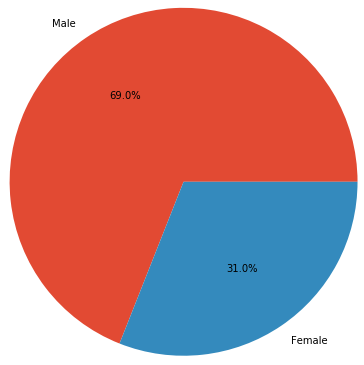

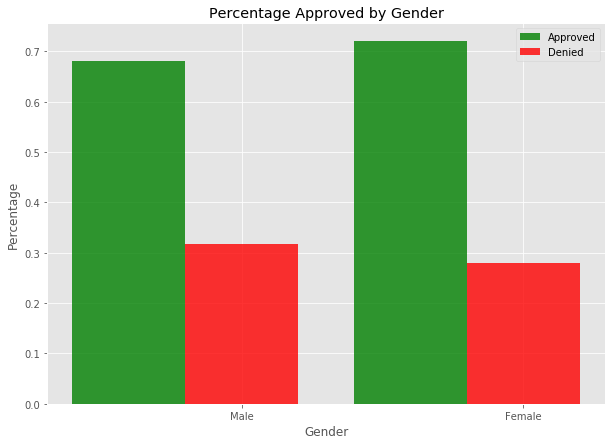

In [95]:
gender_value_counts = data['gender'].value_counts()

plt.pie(gender_value_counts, labels = ['Male', 'Female'],  
        radius = 2, autopct='%1.1f%%')

male = data[data['job'] == 0]
female = data[data['job'] == 1]

male_percentages = male['class'].value_counts() / len(male)
female_percentages = female['class'].value_counts() / len(female)

gender_approved = [male_percentages[1], female_percentages[1]]
gender_denied = [male_percentages[0], female_percentages[0]]

# data to plot
n_groups = 2
 
# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, gender_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, gender_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Gender')
plt.xticks(index + bar_width, ('Male','Female'))
plt.legend()

plt.show()
print('')

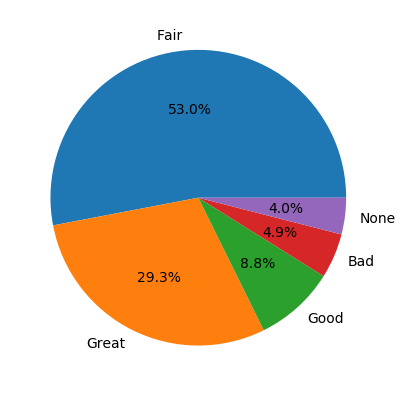

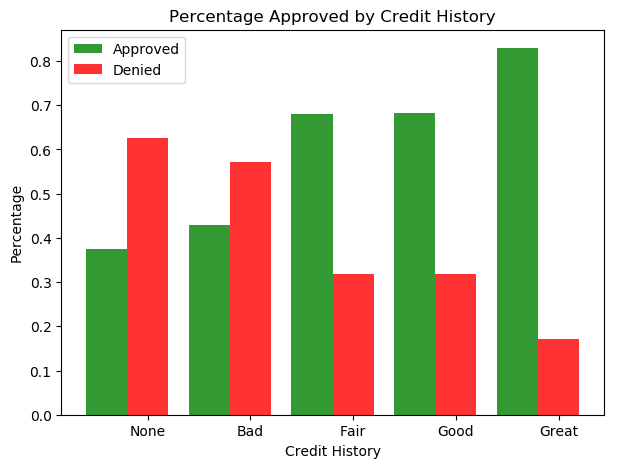

In [38]:
credhis_value_counts = data['credit_history'].value_counts()

plt.pie(credhis_value_counts, labels = ['Fair', 'Great', 'Good', 'Bad', 'None'],  
        radius = 1, autopct='%1.1f%%')

none = data[data['credit_history'] == 0]
bad = data[data['credit_history'] == 1]
fair = data[data['credit_history'] == 2]
good = data[data['credit_history'] == 3]
great = data[data['credit_history'] == 4]

none_percentages = none['class'].value_counts() / len(none)
bad_percentages = bad['class'].value_counts() / len(bad)
fair_percentages = fair['class'].value_counts() / len(fair)
good_percentages = good['class'].value_counts() / len(good)
great_percentages = great['class'].value_counts() / len(great)

credhis_approved = [none_percentages[1], bad_percentages[1], fair_percentages[1], 
                   good_percentages[1], great_percentages[1]]
credhis_denied = [none_percentages[0], bad_percentages[0], fair_percentages[0], 
                 good_percentages[0], great_percentages[0]]

# data to plot
n_groups = 5
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, credhis_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, credhis_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Credit History')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Credit History')
plt.xticks(index + bar_width, ('None', 'Bad','Fair', 'Good', 'Great'))
plt.legend()

plt.show()
print('')

1    603
0    183
2    103
3     63
4     48
Name: savings_balance, dtype: int64


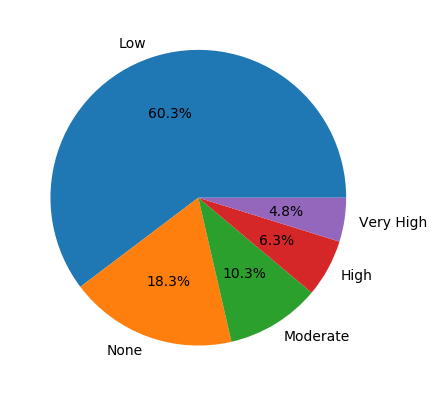

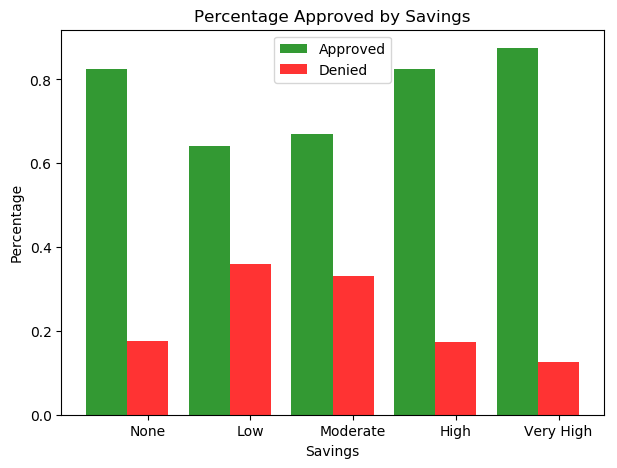

In [36]:
savings_value_counts = data['savings_balance'].value_counts()

plt.pie(savings_value_counts, labels = [ 'Low','None', 'Moderate', 'High','Very High'],  
        radius = 1, autopct='%1.1f%%')

print(savings_value_counts)

none = data[data['savings_balance'] == 0]
low = data[data['savings_balance'] == 1]
moderate = data[data['savings_balance'] == 2]
high = data[data['savings_balance'] == 3]
very_high = data[data['savings_balance'] == 4]

none_percentages = none['class'].value_counts() / len(none)
low_percentages = low['class'].value_counts() / len(low)
moderate_percentages = moderate['class'].value_counts() / len(moderate)
high_percentages = high['class'].value_counts() / len(high)
very_high_percentages = very_high['class'].value_counts() / len(very_high)

savings_approved = [none_percentages[1], low_percentages[1], moderate_percentages[1], 
                   high_percentages[1], very_high_percentages[1]]
savings_denied = [none_percentages[0], low_percentages[0], moderate_percentages[0], 
                 high_percentages[0], very_high_percentages[0]]

# data to plot
n_groups = 5
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, savings_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, savings_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Savings')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Savings')
plt.xticks(index + bar_width, ('None', 'Low','Moderate', 'High', 'Very High'))
plt.legend()

plt.show()
print('')

## Creating the Machine Learning Algorithm

In [33]:
# y = data['class']
# data.drop(["class"],axis = 1, inplace = True)
# X = data

A = data[data['class'] == 1]
a = A['class']
A.drop(["class"],axis = 1, inplace = True)

N = data[data['class'] == 0]
n = N['class']
N.drop(["class"],axis = 1, inplace = True)

A_train, A_test, a_train, a_test = train_test_split(A,a,train_size = 0.215)
N_train, N_test, n_train, n_test = train_test_split(N,n,train_size = 0.5)

X_train = pd.concat([A_train,N_train])
X_test = pd.concat([A_test,N_test])
y_train = pd.concat([a_train,n_train])
y_test = pd.concat([a_test,n_test])

X_train

C:\Users\hanma\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\hanma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,age,checking_balance,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance
803,35.0,0,4,12.0,976.0,2.0,1,0,2,2,3,0
459,32.0,0,2,18.0,4594.0,1.0,1,0,2,2,3,1
400,39.0,0,2,18.0,1473.0,1.0,1,0,2,2,3,1
361,37.0,3,2,12.0,3399.0,1.0,1,0,2,3,3,0
943,42.0,0,4,4.0,1455.0,3.0,1,0,2,1,0,1
811,28.0,2,2,6.0,484.0,1.0,1,0,2,1,3,1
386,21.0,0,2,18.0,1126.0,1.0,1,1,1,2,3,0
934,23.0,1,2,12.0,1498.0,1.0,1,1,2,2,3,1
177,52.0,1,4,6.0,338.0,2.0,1,0,2,2,3,3
269,25.0,0,2,24.0,999.0,2.0,1,0,2,2,3,0


### Percepitron Algorithm

This is our baseline algorithm

Since the Perceptron algorithm uses float variable types we will just use certain columns from our dataset.

In [7]:
# Build a classifier using the training dataset.
perceptron = Perceptron(tol = 1e-3, fit_intercept = True, max_iter = 100)
perceptron.fit(X_train, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = perceptron.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.7857142857142857
Confusion Matrix:
[[  0 150]
 [  0 550]]


In [17]:
# Scale the dataset 

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Build a classifier using the training dataset.
perceptron = Perceptron(tol = 1e-3, fit_intercept = True, max_iter = 100)
perceptron.fit(X_train_std, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = perceptron.predict(X_test_std)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.5014285714285714
Confusion Matrix:
[[ 89  61]
 [288 262]]


C:\Users\hanma\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\hanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [18]:
# Scale the dataset 

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Build a classifier using the training dataset.
perceptron = Perceptron(n_iter=100, eta0=0.1, random_state=0)
perceptron.fit(X_train_std, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = perceptron.predict(X_test_std)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.6157142857142858
Confusion Matrix:
[[ 43 107]
 [162 388]]


C:\Users\hanma\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\hanma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\hanma\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### SVM Model

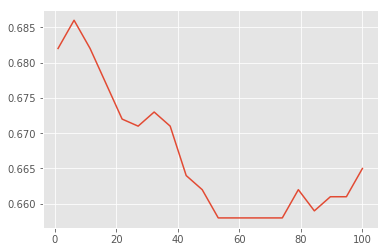

In [47]:
# Finding the best value of C by using cross_val_score and plotting the results.
Cs = np.linspace(1,100,20)
Accuracies = np.zeros(Cs.shape[0])

for i,C in enumerate(Cs):
    C_test = svm.SVC(kernel='rbf', C = C, gamma = 'scale')
    scores = cross_val_score(estimator = C_test, X = X, y = y, cv=5, scoring='accuracy')
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()

From this plot, we can tell the value of C which results in the highest accuracy is 5. 

In [48]:
# Split the data into a training and test set. 
X_train, X_test, y_train, y_test = train_test_split(X, y)


# Build a classifier using the training dataset.
SVM_model = svm.SVC(kernel='rbf', C = 5, gamma = 'scale')
SVM_model.fit(X_train, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = SVM_model.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.7
Confusion Matrix:
[[  7  69]
 [  6 168]]


### Decision Tree

In [27]:
decisionTree = tree.DecisionTreeClassifier()

# fit the tree with the traing data
decisionTree = decisionTree.fit(X_train, y_train)

# predict with the training data
y_pred_train = decisionTree.predict(X_train)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  1.0
Accuracy on test data =  0.6257142857142857


When training and testing using all of our data we get a 100% accuracy on the training data set which is expected since this would overfit the data. But, we still recieve a faily low accuracy on our test set.

Let's work only with the numerical and categorical variables and omit values could contain information that is hard to make sense of without more context.

In [6]:
A = X[['cc_age', 'credit_history', 'credit_usage', 'current_balance', 'existing_credits', 'location', 'num_dependents']]
decisionTree = tree.DecisionTreeClassifier()

ATrain, ATest, yTrain, yTest = train_test_split(A,y)
# fit the tree with the traing data
decisionTree = decisionTree.fit(ATrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(ATrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(ATest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data =  1.0
Accuracy on test data =  0.608


What we can take away from this Decision Tree is that if we focus our analysis on factors that are mainly concerned with the applicants credit, then we can get a fairly accurate prediction on whether an applicant would be approved for a loan or not at an accuracy of 70%.

### Random Forest

In [7]:
forest =  RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)

trained_forest = forest.fit(XTrain, yTrain)

y_pred_train = trained_forest.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = trained_forest.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  1.0
Accuracy on test data=  0.68
